In [1]:
import os
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_user = os.getenv('DB_USER')
db_pass = os.getenv('DB_PASS')
db_name = os.getenv('DB_NAME')

connection = f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection)

In [3]:
table = 'customers'
query = f"""
SELECT event_time, price, user_id
FROM {table}
WHERE event_type = 'purchase'
AND event_time >= '2022-10-01' 
AND event_time <= '2023-02-28';
"""

In [4]:
# Ejecutar la consulta y cargar los datos en un DataFrame
try:
    data = pd.read_sql(query, engine)
except Exception as e:
    print(f"Error al conectar o consultar la base de datos: {e}")

# Mostrar las primeras filas del DataFrame
data.head()

,event_time,price,user_id
0,2022-12-01 00:17:50,0.38,473613801
1,2022-12-01 00:17:50,0.38,473613801
2,2022-12-01 00:17:50,0.38,473613801
3,2022-12-01 00:17:50,0.37,473613801
4,2022-12-01 00:17:50,0.38,473613801


In [6]:
# Calcular el número de usuarios únicos por día
daily_unique_users = data.groupby([data['event_time'].dt.date.rename('timeAt')])['user_id'].nunique()

print(daily_unique_users)

timeAt
2022-10-01    1001
2022-10-02    1045
2022-10-03    1048
2022-10-04     892
2022-10-05     708
              ... 
2023-01-27    2014
2023-01-28    2007
2023-01-29     988
2023-01-30     964
2023-01-31     967
Name: user_id, Length: 123, dtype: int64


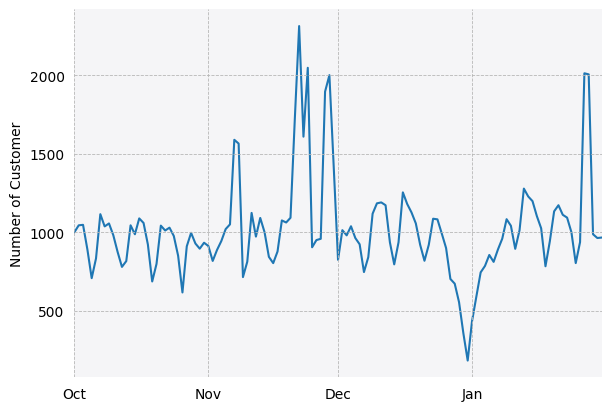

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
ax.plot(daily_unique_users.index.tolist(), daily_unique_users.values.tolist(), zorder=1)
ax.margins(x=0)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.grid(True, zorder=0, color='#B7B7B7', linestyle='--', linewidth=0.6) 
ax.set_facecolor('#F5F5F7')  # Fondo azul claro en hexadecimal
ax.spines['top'].set_visible(False)      # Desactivar borde superior
ax.spines['right'].set_visible(False)    # Desactivar borde derecho
ax.spines['left'].set_visible(False)     # Desactivar borde izquierdo
ax.spines['bottom'].set_visible(False)   # Desactivar borde inferior
# Quitar las marcas (ticks) del eje X y Y
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)

ax.set_yticks([500, 1000, 1500, 2000], ['500', '1000', '1500', '2000'])
ax.set_ylabel('Number of Customer')
plt.show()

# Bar Chart

Sales for Month

In [8]:
sales = data['price'].groupby([data['event_time'].dt.month.rename('month'), data['event_time'].dt.year.rename('year')]).sum()
sales = sales.sort_index(level=['year', 'month'])
print(sales)

month  year
10     2022    1210300.53
11     2022    1530243.71
12     2022    1077089.98
1      2023    1320618.99
Name: price, dtype: float64


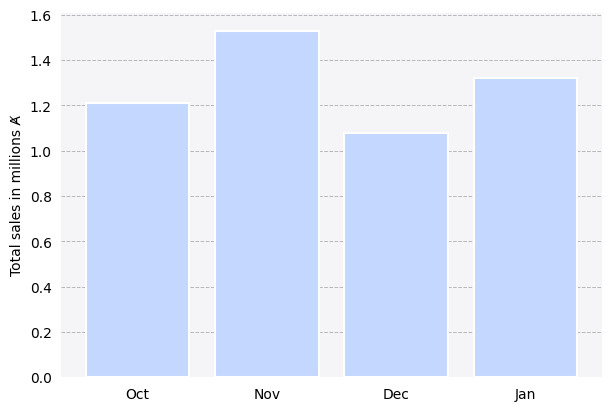

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.bar(
 range(0, len(sales)),             # Posición de las barras
    sales.values.tolist(),         # Valores de las barras
    color='#C4D7FF',               # Color de relleno de las barras
    edgecolor='white',             # Borde de las barras en blanco
    linewidth=1.5,                 # Grosor del borde blanco
    zorder=3                       # Colocar las barras en frente de la cuadrícula
)
ax.margins(x=0.05)
# Configurar las etiquetas del eje X
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xticks(range(0, len(sales)), ['Oct', 'Nov', 'Dec', 'Jan'])

# Etiqueta del eje Y con símbolo especial
ax.set_ylabel('Total sales in millions Ⱥ')

ax.set_facecolor('#F5F5F7')  # Fondo
ax.spines['top'].set_visible(False)      # Desactivar borde superior
ax.spines['right'].set_visible(False)    # Desactivar borde derecho
ax.spines['left'].set_visible(False)     # Desactivar borde izquierdo
ax.spines['bottom'].set_visible(False)   # Desactivar borde inferior

# Quitar las marcas (ticks) del eje X y Y
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)
ax.grid(axis='y', color='#B7B7B7', linestyle='--', linewidth=0.7, zorder=0)

# Formatear las etiquetas del eje Y
def millions_formatter(x, pos):
    return f'{x / 1_000_000:.1f}'  # Convertir los valores a millones

# Desactivar la notación científica en el eje Y
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()

# Stacked area plot

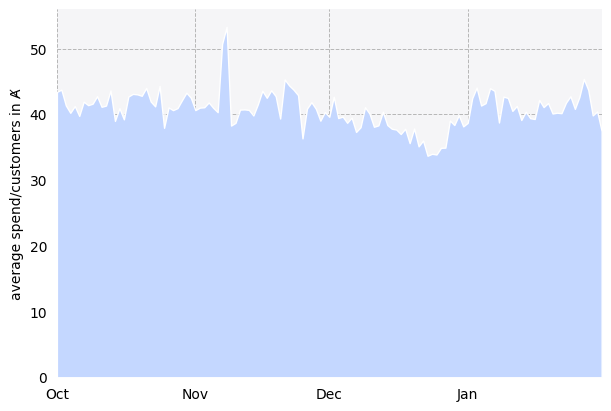

In [10]:
average = data['price'].groupby([data['event_time'].dt.date.rename('At'), data['user_id'].rename('user')]).sum()
average = average.groupby('At').mean()

fig, ax = plt.subplots(1, 1, figsize=(6,4), layout='constrained')
ax.stackplot(average.index.tolist(), average.values.tolist(), colors=['#C4D7FF'], edgecolor='white', zorder=3)

ax.margins(x=0)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.grid(True, zorder=0)
ax.set_ylabel('average spend/customers in Ⱥ')

# Quitar las marcas (ticks) del eje X y Y
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=False, right=False)
ax.grid(axis='y', color='#B7B7B7', linestyle='--', linewidth=0.7, zorder=0)

# Configurar la cuadrícula del eje Y con líneas blancas
ax.grid(color='#B7B7B7', linestyle='--', linewidth=0.7, zorder=0)

ax.set_facecolor('#F5F5F7')  # Fondo
ax.spines['top'].set_visible(False)      # Desactivar borde superior
ax.spines['right'].set_visible(False)    # Desactivar borde derecho
ax.spines['left'].set_visible(False)     # Desactivar borde izquierdo
ax.spines['bottom'].set_visible(False)   # Desactivar borde inferior

plt.show()